***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.2)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While changing the primary capsule dimension ($P_{capsule} = 16D$). Training with $L_{cons}$
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss_P16')

FOLDER CREATED =  ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss_P16


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 16

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), 
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.3009 - prediction_coarse_accuracy: 0.8434 - prediction_medium_accuracy: 0.4004 - prediction_fine_accuracy: 0.2117
  • Coarse Accuracy = 84.34% | Val_Accuracy = 88.24% | LossWeight = 0.16 
  • Medium Accuracy = 40.04% | Val_Accuracy = 51.47% | LossWeight = 0.42 
  • Fine   Accuracy = 21.17% | Val_Accuracy = 34.99% | LossWeight = 0.42 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.34990, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 60s 64ms/step - loss: 0.3009 - prediction_coarse_accuracy: 0.8434 - prediction_medium_accuracy: 0.4004 - prediction_fine_accuracy: 0.2117 - val_loss: 0.2161 - val_prediction_coarse_accuracy: 0.8824 - val_prediction_medium_accuracy: 0.5147 - val_prediction_fine_accuracy: 0.3499 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1867 - prediction_coarse_accu

781/781 [==============================] - ETA: 0s - loss: 0.1300 - prediction_coarse_accuracy: 0.9167 - prediction_medium_accuracy: 0.7425 - prediction_fine_accuracy: 0.6268
  • Coarse Accuracy = 91.67% | Val_Accuracy = 93.65% | LossWeight = 0.18 
  • Medium Accuracy = 74.25% | Val_Accuracy = 77.39% | LossWeight = 0.39 
  • Fine   Accuracy = 62.68% | Val_Accuracy = 67.03% | LossWeight = 0.43 

Epoch 9: val_prediction_fine_accuracy improved from 0.65390 to 0.67030, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 41s 52ms/step - loss: 0.1300 - prediction_coarse_accuracy: 0.9167 - prediction_medium_accuracy: 0.7425 - prediction_fine_accuracy: 0.6268 - val_loss: 0.0968 - val_prediction_coarse_accuracy: 0.9365 - val_prediction_medium_accuracy: 0.7739 - val_prediction_fine_accuracy: 0.6703 - lr: 0.0010
Epoch 10/100
780/781 [============================>.] - ETA: 0s - loss: 0.1231 - prediction_coarse_accuracy: 0.

Epoch 18/100
780/781 [============================>.] - ETA: 0s - loss: 0.0984 - prediction_coarse_accuracy: 0.9435 - prediction_medium_accuracy: 0.8242 - prediction_fine_accuracy: 0.7485
  • Coarse Accuracy = 94.36% | Val_Accuracy = 95.80% | LossWeight = 0.18 
  • Medium Accuracy = 82.42% | Val_Accuracy = 82.87% | LossWeight = 0.40 
  • Fine   Accuracy = 74.84% | Val_Accuracy = 76.28% | LossWeight = 0.42 

Epoch 18: val_prediction_fine_accuracy did not improve from 0.77010
781/781 [==============================] - 40s 52ms/step - loss: 0.0984 - prediction_coarse_accuracy: 0.9436 - prediction_medium_accuracy: 0.8242 - prediction_fine_accuracy: 0.7484 - val_loss: 0.0714 - val_prediction_coarse_accuracy: 0.9580 - val_prediction_medium_accuracy: 0.8287 - val_prediction_fine_accuracy: 0.7628 - lr: 6.6342e-04
Epoch 19/100
780/781 [============================>.] - ETA: 0s - loss: 0.0974 - prediction_coarse_accuracy: 0.9421 - prediction_medium_accuracy: 0.8296 - prediction_fine_accuracy: 0.

Epoch 27/100
780/781 [============================>.] - ETA: 0s - loss: 0.0815 - prediction_coarse_accuracy: 0.9543 - prediction_medium_accuracy: 0.8747 - prediction_fine_accuracy: 0.8165
  • Coarse Accuracy = 95.43% | Val_Accuracy = 97.00% | LossWeight = 0.20 
  • Medium Accuracy = 87.48% | Val_Accuracy = 87.13% | LossWeight = 0.38 
  • Fine   Accuracy = 81.66% | Val_Accuracy = 81.81% | LossWeight = 0.42 

Epoch 27: val_prediction_fine_accuracy did not improve from 0.82360
781/781 [==============================] - 47s 60ms/step - loss: 0.0815 - prediction_coarse_accuracy: 0.9543 - prediction_medium_accuracy: 0.8748 - prediction_fine_accuracy: 0.8166 - val_loss: 0.0550 - val_prediction_coarse_accuracy: 0.9700 - val_prediction_medium_accuracy: 0.8713 - val_prediction_fine_accuracy: 0.8181 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0805 - prediction_coarse_accuracy: 0.9571 - prediction_medium_accuracy: 0.8771 - prediction_fine_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.0712 - prediction_coarse_accuracy: 0.9635 - prediction_medium_accuracy: 0.9042 - prediction_fine_accuracy: 0.8572
  • Coarse Accuracy = 96.35% | Val_Accuracy = 97.22% | LossWeight = 0.20 
  • Medium Accuracy = 90.42% | Val_Accuracy = 88.43% | LossWeight = 0.38 
  • Fine   Accuracy = 85.72% | Val_Accuracy = 83.83% | LossWeight = 0.42 

Epoch 36: val_prediction_fine_accuracy did not improve from 0.84240
781/781 [==============================] - 43s 55ms/step - loss: 0.0712 - prediction_coarse_accuracy: 0.9635 - prediction_medium_accuracy: 0.9042 - prediction_fine_accuracy: 0.8572 - val_loss: 0.0490 - val_prediction_coarse_accuracy: 0.9722 - val_prediction_medium_accuracy: 0.8843 - val_prediction_fine_accuracy: 0.8383 - lr: 2.6352e-04
Epoch 37/100
780/781 [============================>.] - ETA: 0s - loss: 0.0697 - prediction_coarse_accuracy: 0.9650 - prediction_medium_accuracy: 0.9073 - prediction_fine_accuracy: 0.8617
  • Coar

780/781 [============================>.] - ETA: 0s - loss: 0.0639 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9229 - prediction_fine_accuracy: 0.8831
  • Coarse Accuracy = 96.93% | Val_Accuracy = 97.61% | LossWeight = 0.21 
  • Medium Accuracy = 92.28% | Val_Accuracy = 89.25% | LossWeight = 0.37 
  • Fine   Accuracy = 88.30% | Val_Accuracy = 85.04% | LossWeight = 0.42 

Epoch 45: val_prediction_fine_accuracy did not improve from 0.85070
781/781 [==============================] - 43s 55ms/step - loss: 0.0639 - prediction_coarse_accuracy: 0.9693 - prediction_medium_accuracy: 0.9228 - prediction_fine_accuracy: 0.8830 - val_loss: 0.0466 - val_prediction_coarse_accuracy: 0.9761 - val_prediction_medium_accuracy: 0.8925 - val_prediction_fine_accuracy: 0.8504 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0639 - prediction_coarse_accuracy: 0.9711 - prediction_medium_accuracy: 0.9246 - prediction_fine_accuracy: 0.8846
  • Coar

781/781 [==============================] - 42s 54ms/step - loss: 0.0608 - prediction_coarse_accuracy: 0.9729 - prediction_medium_accuracy: 0.9310 - prediction_fine_accuracy: 0.8966 - val_loss: 0.0455 - val_prediction_coarse_accuracy: 0.9765 - val_prediction_medium_accuracy: 0.8934 - val_prediction_fine_accuracy: 0.8530 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0619 - prediction_coarse_accuracy: 0.9728 - prediction_medium_accuracy: 0.9291 - prediction_fine_accuracy: 0.8924
  • Coarse Accuracy = 97.28% | Val_Accuracy = 97.62% | LossWeight = 0.20 
  • Medium Accuracy = 92.91% | Val_Accuracy = 89.17% | LossWeight = 0.37 
  • Fine   Accuracy = 89.24% | Val_Accuracy = 84.88% | LossWeight = 0.42 

Epoch 55: val_prediction_fine_accuracy did not improve from 0.85460
781/781 [==============================] - 52s 67ms/step - loss: 0.0619 - prediction_coarse_accuracy: 0.9728 - prediction_medium_accuracy: 0.9291 - prediction_fine_accuracy: 0.8924 - 

Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0597 - prediction_coarse_accuracy: 0.9734 - prediction_medium_accuracy: 0.9364 - prediction_fine_accuracy: 0.9037
  • Coarse Accuracy = 97.34% | Val_Accuracy = 97.73% | LossWeight = 0.22 
  • Medium Accuracy = 93.64% | Val_Accuracy = 89.79% | LossWeight = 0.37 
  • Fine   Accuracy = 90.37% | Val_Accuracy = 85.63% | LossWeight = 0.42 

Epoch 64: val_prediction_fine_accuracy improved from 0.85600 to 0.85630, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 66s 85ms/step - loss: 0.0597 - prediction_coarse_accuracy: 0.9734 - prediction_medium_accuracy: 0.9364 - prediction_fine_accuracy: 0.9037 - val_loss: 0.0447 - val_prediction_coarse_accuracy: 0.9773 - val_prediction_medium_accuracy: 0.8979 - val_prediction_fine_accuracy: 0.8563 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0589 - prediction_c

781/781 [==============================] - 67s 85ms/step - loss: 0.0577 - prediction_coarse_accuracy: 0.9744 - prediction_medium_accuracy: 0.9389 - prediction_fine_accuracy: 0.9092 - val_loss: 0.0444 - val_prediction_coarse_accuracy: 0.9778 - val_prediction_medium_accuracy: 0.8953 - val_prediction_fine_accuracy: 0.8574 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0589 - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9386 - prediction_fine_accuracy: 0.9083
  • Coarse Accuracy = 97.41% | Val_Accuracy = 97.83% | LossWeight = 0.22 
  • Medium Accuracy = 93.86% | Val_Accuracy = 89.52% | LossWeight = 0.37 
  • Fine   Accuracy = 90.83% | Val_Accuracy = 85.59% | LossWeight = 0.41 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.85810
781/781 [==============================] - 57s 73ms/step - loss: 0.0589 - prediction_coarse_accuracy: 0.9741 - prediction_medium_accuracy: 0.9386 - prediction_fine_accuracy: 0.9083 - 

781/781 [==============================] - ETA: 0s - loss: 0.0570 - prediction_coarse_accuracy: 0.9754 - prediction_medium_accuracy: 0.9417 - prediction_fine_accuracy: 0.9135
  • Coarse Accuracy = 97.54% | Val_Accuracy = 97.77% | LossWeight = 0.22 
  • Medium Accuracy = 94.17% | Val_Accuracy = 89.90% | LossWeight = 0.37 
  • Fine   Accuracy = 91.35% | Val_Accuracy = 85.88% | LossWeight = 0.41 

Epoch 83: val_prediction_fine_accuracy improved from 0.85810 to 0.85880, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 68s 87ms/step - loss: 0.0570 - prediction_coarse_accuracy: 0.9754 - prediction_medium_accuracy: 0.9417 - prediction_fine_accuracy: 0.9135 - val_loss: 0.0440 - val_prediction_coarse_accuracy: 0.9777 - val_prediction_medium_accuracy: 0.8990 - val_prediction_fine_accuracy: 0.8588 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0575 - prediction_coarse_accurac

781/781 [==============================] - 64s 82ms/step - loss: 0.0570 - prediction_coarse_accuracy: 0.9749 - prediction_medium_accuracy: 0.9411 - prediction_fine_accuracy: 0.9127 - val_loss: 0.0439 - val_prediction_coarse_accuracy: 0.9785 - val_prediction_medium_accuracy: 0.8977 - val_prediction_fine_accuracy: 0.8580 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0572 - prediction_coarse_accuracy: 0.9759 - prediction_medium_accuracy: 0.9409 - prediction_fine_accuracy: 0.9127
  • Coarse Accuracy = 97.59% | Val_Accuracy = 97.78% | LossWeight = 0.21 
  • Medium Accuracy = 94.09% | Val_Accuracy = 89.80% | LossWeight = 0.37 
  • Fine   Accuracy = 91.27% | Val_Accuracy = 85.81% | LossWeight = 0.41 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.85890
781/781 [==============================] - 60s 77ms/step - loss: 0.0572 - prediction_coarse_accuracy: 0.9759 - prediction_medium_accuracy: 0.9409 - prediction_fine_accuracy: 0.9127 - 

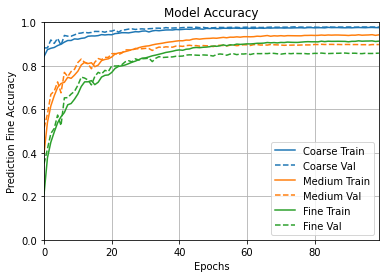

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

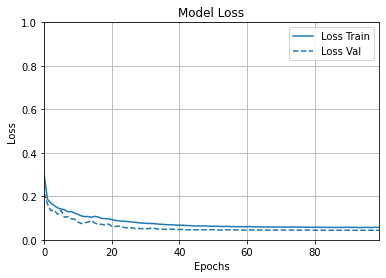

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 9s 21ms/step - loss: 0.0763 - prediction_coarse_loss: 0.0171 - prediction_medium_loss: 0.0768 - prediction_fine_loss: 0.1074 - prediction_coarse_accuracy: 0.9788 - prediction_medium_accuracy: 0.8979 - prediction_fine_accuracy: 0.8583
1. loss ==> 0.07631603628396988
2. prediction_coarse_loss ==> 0.01711132563650608
3. prediction_medium_loss ==> 0.07678607851266861
4. prediction_fine_loss ==> 0.1074303686618805
5. prediction_coarse_accuracy ==> 0.9787999987602234
6. prediction_medium_accuracy ==> 0.8978999853134155
7. prediction_fine_accuracy ==> 0.858299970626831
313/313 [==============================] - 5s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

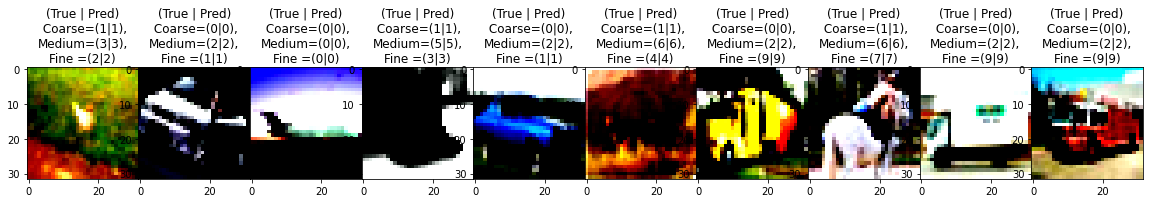

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3898  102]
 [ 110 5890]]

  • MEDIUM LEVEL 
[[ 893   22   27   28    3   13   14]
 [  40  918   30    4    3    3    2]
 [  24   15 1951    1    1    6    2]
 [  33    5    9  793   47   60   53]
 [   7    2    5   20  927   31    8]
 [  16   11   29   57   73 1708  106]
 [  14    4    7   51   39   96 1789]]

  • FINE LEVEL 
[[900   7  29   9   5   3   3   5  24  15]
 [ 10 939   0   1   0   1   1   0   8  40]
 [ 35   4 795  27  38  30  46  15   5   5]
 [ 14   5  36 699  34 107  55  26  10  14]
 [  9   1  42  33 827  17  35  33   3   0]
 [  5   5  23 136  25 753  20  28   2   3]
 [  7   1  20  22   4   8 931   3   2   2]
 [  6   0  12  22  28  21   5 899   1   6]
 [ 41   9   4   5   1   0   2   0 922  16]
 [ 15  50   1   4   0   1   0   0  11 918]]

  • Classification Report 


  • COARSE LEVEL 


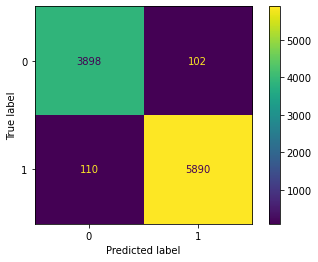

              precision    recall  f1-score   support

           0    0.97255   0.97450   0.97353      4000
           1    0.98298   0.98167   0.98232      6000

    accuracy                        0.97880     10000
   macro avg    0.97777   0.97808   0.97792     10000
weighted avg    0.97881   0.97880   0.97880     10000


  • MEDIUM LEVEL 


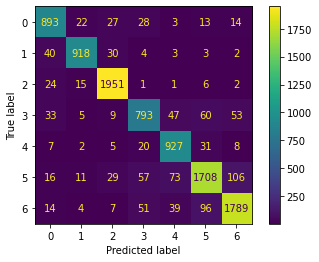

              precision    recall  f1-score   support

           0    0.86952   0.89300   0.88111      1000
           1    0.93961   0.91800   0.92868      1000
           2    0.94801   0.97550   0.96156      2000
           3    0.83124   0.79300   0.81167      1000
           4    0.84812   0.92700   0.88581      1000
           5    0.89098   0.85400   0.87210      2000
           6    0.90628   0.89450   0.90035      2000

    accuracy                        0.89790     10000
   macro avg    0.89054   0.89357   0.89161     10000
weighted avg    0.89790   0.89790   0.89753     10000


  • FINE LEVEL 


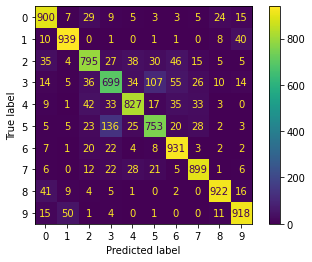

              precision    recall  f1-score   support

           0    0.86372   0.90000   0.88149      1000
           1    0.91969   0.93900   0.92924      1000
           2    0.82640   0.79500   0.81040      1000
           3    0.72965   0.69900   0.71399      1000
           4    0.85967   0.82700   0.84302      1000
           5    0.80021   0.75300   0.77589      1000
           6    0.84791   0.93100   0.88751      1000
           7    0.89098   0.89900   0.89497      1000
           8    0.93320   0.92200   0.92757      1000
           9    0.90088   0.91800   0.90936      1000

    accuracy                        0.85830     10000
   macro avg    0.85723   0.85830   0.85734     10000
weighted avg    0.85723   0.85830   0.85734     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9112299999999999 
Hierarchical Recall = 0.9141333333333334 
Hierarchical F1-Score = 0.9124285714285714 
Consistency =  0.9844 
Exact Match =  0.8528
